#### Case 2: Liquid hydrogen ($LH_2$) in a 2033 $\text{m}^3$ tank

This application corresponds to liquid hydrogen storage in the NASA's Space Launch System. It consists of a 2033 $m^3$ storage tank [NASA](https://www.energy.gov/sites/default/files/2021-10/new-lh2-sphere.pdf) in a tank with 8.4 m diameter and 40 m height. It will be assumed the following operation scenarios:

* Daily boil-off rate of 0.1%  
* Storage at atmospheric pressure with continuous removal of boil-off gas

For purposes of the example, it is assumed that the storage tank is passively insulated with perlite.

03/09/2024: Illustration of how to use SciPy to optimise

In [1]:
# Scientific computing
import numpy as np

# Visualisation
import matplotlib.pyplot as plt

# Import the storage tank Class
from cryoevap.storage_tanks import Tank

# Import Cryogen class
from cryoevap.cryogens import Cryogen

#### Setup tank and cryogen properties


In [2]:
# Cylindrical storage tank properties
Q_roof = 0 # Roof heat ingress / W
d_i = 8 # Internal diameter / m
d_o = 8.4   # External diameter / m
T_air = 293.15 # Temperature of the environment K

# Set overall heat transfer coefficient through the walls for liquid and vapour
U_L = 3.73e-1 # W/m2/K
U_V = 3.73e-1 # W/m2/K

# Specify heat transfer rate at the bottom
# This will represent the heat conduction from the piping system
Q_b = 100 # W, 

# Vertically orientated cylindrical tank volume
V_tank = 2033 #m^3

# Initial liquid filling / Dimensionless
LF = 0.50 

# Specify tank operating pressure
P = 101325 # Pa

# Initialize mid-scale tank
mid_tank = Tank(d_i, d_o, V_tank, LF)
mid_tank.set_HeatTransProps(U_L, U_V, T_air, Q_b, Q_roof, eta_w= 0.8)

# Keep the tank roof insulated
mid_tank.U_roof = 0

# Initialise cryogen
hydrogen = Cryogen(name = "hydrogen")
hydrogen.set_coolprops(P)

# Set cryogen
mid_tank.cryogen = hydrogen

Calculate initial evaporation rate and transient period

In [3]:
mid_tank.LF

0.5

In [4]:
# Calculate initial evaporation rate
print("The initial evaporation rate of " + hydrogen.name + " is %.1f kg/h" % (mid_tank.b_l_dot * 3600))

# Estimate transient period duration
print("Transient period = %.3f s " % mid_tank.tau)

# Minimum number of hours to achieve steady state 
tau_h = (np.floor(mid_tank.tau / 3600) + 1)

# Print simulation time of the transient period for short-term storage
print("Simulation time: %.0i h" % tau_h )

# Calculate boil-off rate
BOR = (mid_tank.b_l_dot * 24 * 3600) / (mid_tank.V * mid_tank.LF * mid_tank.cryogen.rho_L)
print("BOR = %.3f %%" % (BOR * 100))

The initial evaporation rate of hydrogen is 8.6 kg/h
Transient period = 1127967.052 s 
Simulation time: 314 h
BOR = 0.288 %


### Simulation setup and execution

### Define optimisation parameters

In [5]:
# Define vertical spacing
dz = 0.1

# Calculate number of nodes
n_z = 1 + int(np.round(mid_tank.l_V/dz, 0))

# Define dimensionless computational grid
mid_tank.z_grid = np.linspace(0, 1, n_z)

# Define evaporation time as the transient period
# evap_time = 3600 * tau_h

evap_time = 3600
# Time step to plot each vapour temperature profile
mid_tank.plot_interval = evap_time/6

# Time step to record data, relevant for plotting integrated quantities such as
# the vapour to liquid heat transfer rate, Q_VL
mid_tank.time_interval = 60

# mid_tank.evaporate(evap_time)

In [6]:
from scipy.optimize import Bounds, minimize

# Minimum and maximum practical ranges
# of initial liquid filling

# 5% represent ballast voyage
# 95% is the safety limit for potential liquid thermal expansion
bounds = Bounds([0.05], [0.95])

# Define objective function
def BOR_function(LF):

    # Update liquid filling
    mid_tank.LF = LF

    # Execute simulation
    mid_tank.evaporate(evap_time)

    # Calculate objective function
    f = 1 - mid_tank.data['V_L'][-1] / mid_tank.data['V_L'][0]
    
    print("LF = %.3f, f=%.3e" % (LF, f))
    return f    

# Initial liquid filling to optimise

x0 = 0.9 
res = minimize(BOR_function, x0, method='trust-constr', options={'verbose': 1}, bounds=bounds)

/tmp/ipykernel_17375/4018950756.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("LF = %.3f, f=%.3e" % (LF, f))


LF = 0.900, f=7.206e-05
LF = 0.900, f=7.206e-05
LF = 0.844, f=7.602e-05
LF = 0.844, f=7.602e-05
LF = 0.384, f=1.525e-04
LF = 0.384, f=1.525e-04
LF = 0.722, f=8.683e-05
LF = 0.722, f=8.683e-05
LF = 0.801, f=7.946e-05
LF = 0.801, f=7.946e-05
LF = 0.857, f=7.509e-05
LF = 0.857, f=7.509e-05
LF = 0.920, f=7.076e-05
LF = 0.920, f=7.076e-05
LF = 0.945, f=6.920e-05
LF = 0.945, f=6.920e-05
`gtol` termination condition is satisfied.
Number of iterations: 16, function evaluations: 16, CG iterations: 7, optimality: 2.54e-10, constraint violation: 0.00e+00, execution time: 5.9e+01 s.


In [14]:
res

           message: `gtol` termination condition is satisfied.
           success: True
            status: 1
               fun: 6.91974099107373e-05
                 x: [ 9.452e-01]
               nit: 16
              nfev: 16
              njev: 8
              nhev: 0
          cg_niter: 7
      cg_stop_cond: 1
              grad: [-6.370e-05]
   lagrangian_grad: [-2.537e-10]
            constr: [array([ 9.452e-01])]
               jac: [<1x1 sparse matrix of type '<class 'numpy.float64'>'
                    	with 1 stored elements in Compressed Sparse Row format>]
       constr_nfev: [0]
       constr_njev: [0]
       constr_nhev: [0]
                 v: [array([ 6.369e-05])]
            method: tr_interior_point
        optimality: 2.536784571603246e-10
  constr_violation: 0.0
    execution_time: 59.17054271697998
         tr_radius: 2597999.6212934707
    constr_penalty: 1.0
 barrier_parameter: 2.560000000000001e-07
 barrier_tolerance: 2.560000000000001e-07
             niter:

### Visualisation of results

#### Vapour temperature

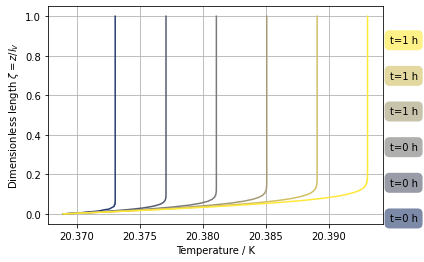

In [7]:
mid_tank.plot_tv(t_unit='h')

Visualise liquid and vapour heat ingresses, $\dot{Q}_{\text{L}}$ and  $\dot{Q}_{\text{V}}$.

The plot also shows the vapour to liquid heat ingress, $\dot{Q}_{VL}$, and  the partition of the vapour heat ingress that is transferred to the interface by the wall directly, $\dot{Q}_{\text{V,w}}$

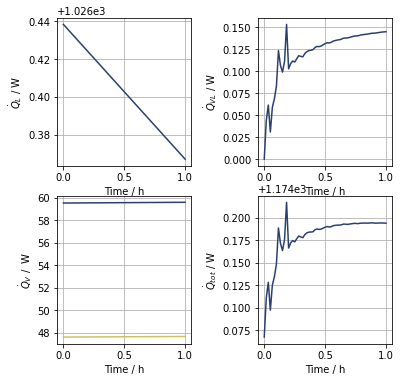

In [8]:
# Specify y-axis units as W, and time units to hours
mid_tank.plot_Q(unit = 'W', t_unit = 'h')

#### Plot liquid volume

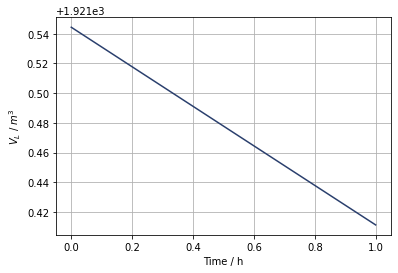

In [9]:
mid_tank.plot_V_L(t_unit='h')

#### Plot evaporation rate, $\dot{B}_{\text{L}}$, and boil-off gas rate, $\dot{B}_{}$

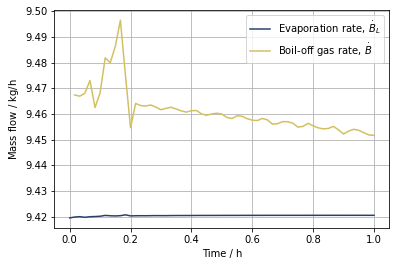

In [10]:
mid_tank.plot_BOG(unit='kg/h', t_unit='h')

Optional: CSV data export

If evaporation data is intended to be post-processed in another software, it can be exported readily with the help of the Pandas package.

In [11]:
# Import pandas 
import pandas as pd

In [12]:
# Create dataframe from dictionary
df_evap = pd.DataFrame.from_dict(mid_tank.data)

# Save file to the current working directory
df_evap.to_csv('iso_LH2_2033m3.csv')

# Show the first five columns of the dataframe in console
df_evap.head()

,Time,Tv_avg,rho_V_avg,Q_VL,Q_L,Q_V,V_L,B_L,BOG,drho_V_avg,dV_L,T_BOG,Q_Vw,Q_tot
0,0,20.368904,1.332170,0.000000,1026.438216,59.536677,1921.544326,0.002617,0.002617,0.000000e+00,0.000000,20.368904,47.629341,1174.067557
1,60,20.369302,1.332136,0.043884,1026.437032,59.537773,1921.542110,0.002617,0.002630,-5.597976e-07,-0.000037,20.369303,47.630219,1174.111135
2,120,20.369699,1.332103,0.061407,1026.435849,59.538870,1921.539894,0.002617,0.002630,-5.582903e-07,-0.000037,20.369703,47.631096,1174.128352
3,180,20.370095,1.332069,0.030819,1026.434665,59.539968,1921.537678,0.002617,0.002630,-5.617897e-07,-0.000037,20.370103,47.631974,1174.097458
4,240,20.370497,1.332035,0.059021,1026.433481,59.541064,1921.535462,0.002617,0.002631,-5.735256e-07,-0.000037,20.370509,47.632851,1174.125353


Plot average vapour and boil-off gas temperature

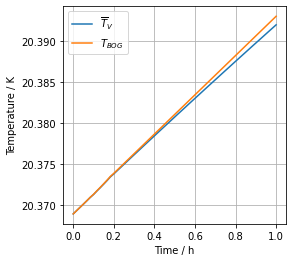

In [13]:
mid_tank.plot_tv_BOG(t_unit='h')

#### References

U.S. Department of Energy. (2021, October). DOE/NASA Advances in Liquid Hydrogen Storage Workshop. Retrieved from [https://www.energy.gov/sites/default/files/2021-10/new-lh2-sphere.pdf]